## Building Custom Object Detection Model

ใน Notebook นี้เราจะสร้าง Object detection model เองด้วยไลบรารี่ [ultralytics](https://github.com/ultralytics/ultralytics) เพื่อใช้ในการอ่านข้อมูลจำเพาะจากบางบริเวณ

In [ ]:
!pip install ultralytics

## Train Model
เราใช้โมเดลตรวจจับวัตถุ YOLOv8 เพื่อฝึกกับชุดข้อมูลที่กำหนดเองใน `dataset_path`.

In [40]:
from pathlib import Path

dataset_path = Path("../assets/YOLOv8_ocr/dataset.yaml").resolve()

เราสามารถเปลี่ยนการตั้งค่าต่างๆได้ใน cli ด้านล่าง และเราสามารถดูตัวอย่างการใช้งานได้จาก [configurations](https://docs.ultralytics.com/usage/cfg/#train-settings)

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data={dataset_path} \
    epochs=300 imgsz=640 plots=True augment=True device=mps\
    mosaic=0.5 flipud=0.0 fliplr=0.0 perspective=0.0001 shear=0.1 \
    degrees=3 translate=0.1 label_smoothing=0.1 mixup=0.1 dropout=0.3

## Inference
ลองรันโมเดลที่เราสร้างขึ้นมาดูว่ามันสามารถตรวจจับ field ต่างๆได้หรือไม่
ซึ่งเราสามารถเปลี่ยนค่าต่างๆได้และสามารถดูตัวอย่างการใช้งานได้จาก [configurations](https://docs.ultralytics.com/modes/predict/#inference-arguments)


0: 640x448 1 อยู่ที่ (chassis_location), 1 ลักษณะ (body_style), 1 ประเภท (vehicle_use), 1 เลขเครื่องยนต์ (engine_number), 1 อยู่ที่ (engine_location), 1 จำนวนเพลาและล้อ (axles_wheels_no), 1227.3ms
Speed: 3.0ms preprocess, 1227.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)


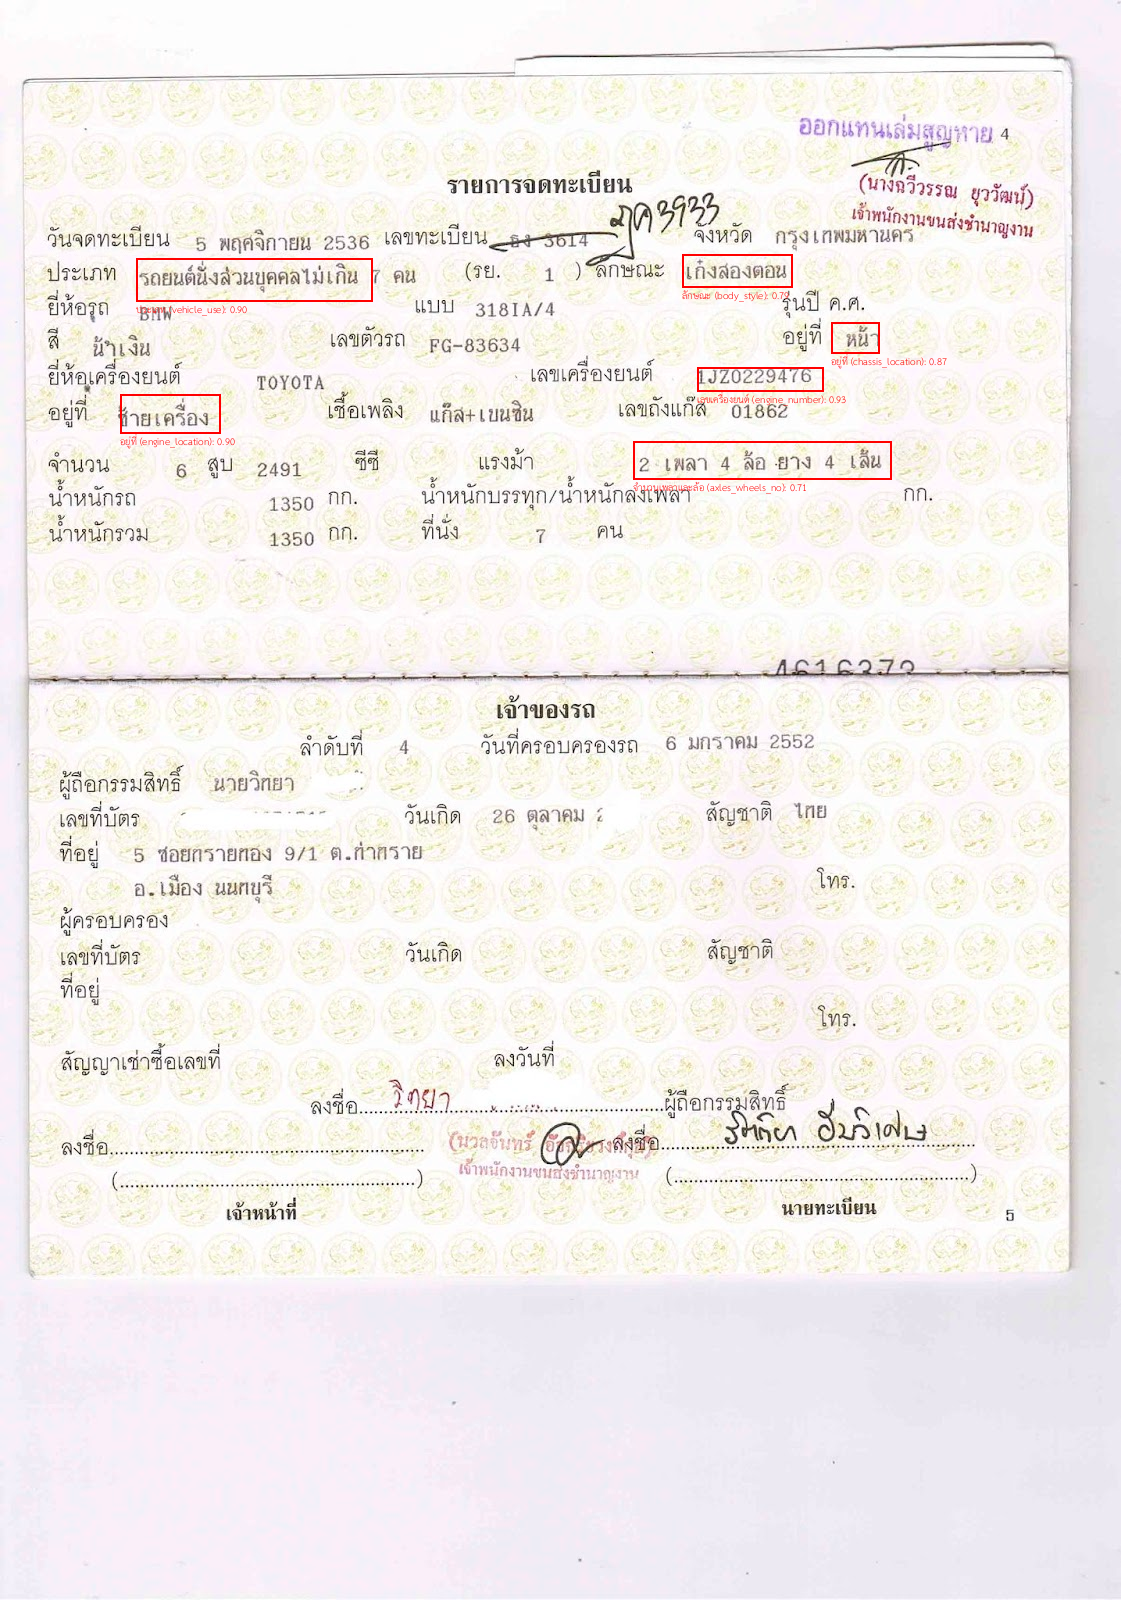

In [ ]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont

FONT = ImageFont.truetype("../assets/THSarabun.ttf", 14)

# The best model checkpoint is saved in the '../runs/train/trainXX/weights/' path, where XX is the session number
checkpoint = Path("../runs/detect/train/weights/best.pt").resolve()
# Load a model from a checkpoint
model = YOLO(checkpoint)

# Get all image paths to run inference on
images = list(Path("../assets/YOLOv8_ocr/test/images").glob("*.png"))

# Run batched inference on a list of images
results = model.predict(images, imgsz=640, conf=0.25, half=True)

# Process results list
for result in results:
    # Get image and draw boxes
    image = Image.fromarray(result.orig_img)
    draw = ImageDraw.Draw(image)

    # Get bounding boxes, class labels, and scores
    class_names = result.names
    bboxes = result.boxes.data[:, :4].round().int().numpy()
    confidence_scores = result.boxes.conf.float().numpy()
    class_predictions = result.boxes.cls.int().numpy()

    # Draw bounding boxes and labels on image
    for bbox, cls, score in zip(bboxes, class_predictions, confidence_scores):
        # Draw bounding box and label
        x1, y1, x2, y2 = bbox
        predicted_class = class_names[cls]
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((bbox[0], bbox[3]), f"{predicted_class}: {score:.2f}", fill="red", font=FONT)

    display(image)